In [1]:
import requests 
import sys, os
import pandas as pd
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt


#### <p style="font-family:verdana"> <span style='color: #138d75' > 1. Load the sales orders to make report for our stake holders.</span></p><p style="font-family:'Courier New'"><span style='color: #138d75' >This sales record was generated in the UK. We are based in Germany, so we need to convert from pounds to euros so that we can give our shareholders a direct and immediately comparable figure. It helps them to make decisions. </span></p>

In [2]:
df= pd.read_csv('orders.csv')                           # The main file containts all sales records. 
df_GBP=pd.read_csv('Euro_2_GBP_HistoricalFX.csv')       # The exchange rate cellected using API.  see the notebook'API_get_euro_2_GBP_HistoricalFX'
df_orderlines = pd.read_csv('orderlines.csv')           # This file contains order order ID and SKU keys. that we need later to get products name from talbe Products.
df_products = pd.read_csv('products.csv')               # This table contains product names for our order report. so we can report not only sales numbers but also present what are the best sell items etc.
df_products = df_products[['sku','name']]               # get only the columns we need. 

#### <p style="font-family:'Courier New'"><span style='color: #138d75' >Let‘s make our 1st talbe clean and ready for tableau report </span></p>

In [3]:
df = df[df['state']=='Completed']
df.sort_values(by=['created_date'])
df.columns = ['order_id', 'created_date', 'total_paid_GBP', 'state']
df['created_date']= pd.to_datetime(df['created_date'], utc=False)
df = df[(df['created_date'] > '2016-12-31')& (df['created_date'] < '2017-2-1')]

df['created_date'] = df['created_date'].apply(lambda x: x.strftime('%Y-%m-%d')) 
df.sort_values(by='created_date')


,order_id,created_date,total_paid_GBP,state
530,299891,2017-01-01,63.98,Completed
388,299742,2017-01-01,48.67,Completed
417,299773,2017-01-01,57.33,Completed
420,299776,2017-01-01,398.99,Completed
424,299780,2017-01-01,22.18,Completed
...,...,...,...,...
18601,318081,2017-01-31,69.97,Completed
18606,318086,2017-01-31,138.87,Completed
18609,318089,2017-01-31,86.43,Completed
18532,318012,2017-01-31,245.70,Completed


In [4]:
df.duplicated().value_counts()

False    5135
dtype: int64

In [5]:
df_GBP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   exchange_rate_date  35 non-null     object 
 1   GBP                 35 non-null     float64
dtypes: float64(1), object(1)
memory usage: 688.0+ bytes


In [6]:
df_FX_Converted=df.merge(df_GBP,left_on='created_date',right_on='exchange_rate_date')
df_FX_Converted['total_paid_EUR']=df_FX_Converted['total_paid_GBP']*df_FX_Converted['GBP']
df_FX_Converted['total_paid_EUR']=df_FX_Converted['total_paid_EUR'].round()
df_FX_Converted.columns=['order_id',
                      'created_date',
                      'total_paid_GBP',
                      'order_state',
                      'exchange_rate_date',
                      'FX_Euro2GBP',
                      'total_paid_EUR']
df_FX_Converted

,order_id,created_date,total_paid_GBP,order_state,exchange_rate_date,FX_Euro2GBP,total_paid_EUR
0,245595,2017-01-21,112.97,Completed,2017-01-21,0.865284,98.0
1,274166,2017-01-21,170.99,Completed,2017-01-21,0.865284,148.0
2,311502,2017-01-21,34.97,Completed,2017-01-21,0.865284,30.0
3,311524,2017-01-21,622.99,Completed,2017-01-21,0.865284,539.0
4,311653,2017-01-21,157.98,Completed,2017-01-21,0.865284,137.0
...,...,...,...,...,...,...,...
5130,316492,2017-01-28,1761.98,Completed,2017-01-28,0.852763,1503.0
5131,316494,2017-01-28,283.05,Completed,2017-01-28,0.852763,241.0
5132,316499,2017-01-28,64.98,Completed,2017-01-28,0.852763,55.0
5133,316506,2017-01-28,5577.98,Completed,2017-01-28,0.852763,4757.0


In [7]:
df_FX_Converted.duplicated().value_counts()

False    5135
dtype: int64

In [8]:
# df_FX_Converted.to_csv('UK_region_sales_in_euro_201701.csv',encoding="utf-8",index = Falsh)

In [9]:
df_orderlines.duplicated().value_counts()

False    293983
dtype: int64

In [10]:
df_orderlines['date'] = pd.to_datetime(df_orderlines['date'])
df_orderlines



df_orderlines = df_orderlines[(df_orderlines['date'] > '2016-12-31')& (df_orderlines['date'] < '2017-2-1')]

df_orderlines['date'] = df_orderlines['date'].apply(lambda x: x.strftime('%Y-%m-%d')) 
df_orderlines.duplicated().value_counts()

False    21557
dtype: int64

In [11]:
df_products.drop_duplicates( keep='last',inplace=True,)

In [12]:
df_products.duplicated().value_counts()


False    10579
dtype: int64

#### <p style="font-family:verdana"> <span style='color: #138d75' > 2. Chunck only the completed order records for our report at this stage.</span></p><p style="font-family:'Courier New'"><span style='color: #138d75' >Let's select only the orders that were completed and already paid for. And have a overall check the data types and see what for a dataset we got.</span></p>

In [13]:
df_oderIDs_ItemNames =df_orderlines.merge(df_products,how='left', on='sku')
df_oderIDs_ItemNames.sort_values(by = 'date')

,id,id_order,product_id,product_quantity,sku,unit_price,date,name
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01,Otterbox iPhone Case Symmetry 2.0 SE / 5s / 5 ...
407,1119876,299918,0,1,SAN0099,42.74,2017-01-01,SanDisk Connect Wireless Flash Drive 64GB Wire...
408,1119877,299919,0,1,APP1646,769.00,2017-01-01,Apple iPhone 32GB Gold 7
409,1119878,299920,0,1,MUV0166,18.99,2017-01-01,"Muvit Bracelet Universal Fino 47-57 ""Lima + Sp..."
410,1119881,299922,0,1,CRU0055,559.99,2017-01-01,Crucial MX300 2TB SSD 7mm
...,...,...,...,...,...,...,...,...
21050,1167245,318135,0,1,JAW0048,29.99,2017-01-31,Jawbone UP2 Black Rope Activity Monitor
21051,1167247,318136,0,1,LGE0035,448.99,2017-01-31,"LG 27UD68-W Monitor 27 ""4K UHD sRGB 99%"
21052,1167253,318137,0,1,LEX0026,21.99,2017-01-31,Lexar JumpDrive Lightning USB 3.0 M20i Pendriv...
21043,1167235,318131,0,1,SAN0110,6.64,2017-01-31,SanDisk Ultra Flair Flash Drive 16GB USB 3.0


In [14]:
df_oderIDs_ItemNames.columns=['id', 'order_id', 'product_id', 'product_quantity', 'sku', 'unit_price',
       'date', 'name']

In [15]:
df_oderIDs_ItemNames.duplicated().value_counts()

False    21557
dtype: int64

#### <p style="font-family:verdana"> <span style='color: #138d75' >3. Formate the column ['created_date'] Object into Dtype.</span></p><p style="font-family:'Courier New'"><span style='color: #138d75' >As we only want to go through a whole procedure. How do we get the foreign exchange(FX) conversion rate for that date through the API based on the guest's payment date. Let's just choose a random month of sales data here. Lest the data is too big and burns the CPU of the computer.</span></p>

In [16]:
report_table_sku_merged = df_FX_Converted.merge(df_oderIDs_ItemNames,how='left', on='order_id')
# report_table_sku_merged = report_table_sku_merged[(report_table_sku_merged['created_date'] > '2016-12-31')& (report_table_sku_merged['created_date'] < '2017-2-1')]
report_table_sku_merged


,order_id,created_date,total_paid_GBP,order_state,exchange_rate_date,FX_Euro2GBP,total_paid_EUR,id,product_id,product_quantity,sku,unit_price,date,name
0,245595,2017-01-21,112.97,Completed,2017-01-21,0.865284,98.0,1154394.0,0.0,2.0,PAC1561,52.99,2017-01-21,"Macally External Hard Drive 1TB 35 ""USB 3.0 SA..."
1,274166,2017-01-21,170.99,Completed,2017-01-21,0.865284,148.0,1154390.0,0.0,1.0,OWC0179,170.99,2017-01-21,OWC USB-C Dock USB 3.1 / HDMI / Audio / GigaEt...
2,311502,2017-01-21,34.97,Completed,2017-01-21,0.865284,30.0,1151040.0,0.0,1.0,APP0927,14.99,2017-01-18,EarPods Apple Headphones with Remote and Mic (...
3,311502,2017-01-21,34.97,Completed,2017-01-21,0.865284,30.0,1154473.0,0.0,2.0,APP0698,9.99,2017-01-21,Apple Lightning Cable Connector to USB 1m Whit...
4,311524,2017-01-21,622.99,Completed,2017-01-21,0.865284,539.0,1151097.0,0.0,1.0,APP0909,622.99,2017-01-18,Apple Mac mini Core i5 14GHz | 8GB RAM | 500GB...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6788,316492,2017-01-28,1761.98,Completed,2017-01-28,0.852763,1503.0,1162973.0,0.0,1.0,LAC0205,287.99,2017-01-28,LaCie d2 Hard Drive 3TB Thunderbolt 2 USB 3.0
6789,316494,2017-01-28,283.05,Completed,2017-01-28,0.852763,241.0,1162968.0,0.0,1.0,WAC0097-A,279.06,2017-01-28,Open - Wacom Intuos Pro M Graphics Tablet
6790,316499,2017-01-28,64.98,Completed,2017-01-28,0.852763,55.0,1162989.0,0.0,1.0,TPL0017,59.99,2017-01-28,TP-Link RE450 coverage Extender - repeater Wi-...
6791,316506,2017-01-28,5577.98,Completed,2017-01-28,0.852763,4757.0,1163005.0,0.0,2.0,PAC0963,2.788.99,2017-01-28,"Apple iMac 27 ""Core i7 Retina 5K 4GHz | 32GB |..."


In [17]:
report_table_sku_merged

,order_id,created_date,total_paid_GBP,order_state,exchange_rate_date,FX_Euro2GBP,total_paid_EUR,id,product_id,product_quantity,sku,unit_price,date,name
0,245595,2017-01-21,112.97,Completed,2017-01-21,0.865284,98.0,1154394.0,0.0,2.0,PAC1561,52.99,2017-01-21,"Macally External Hard Drive 1TB 35 ""USB 3.0 SA..."
1,274166,2017-01-21,170.99,Completed,2017-01-21,0.865284,148.0,1154390.0,0.0,1.0,OWC0179,170.99,2017-01-21,OWC USB-C Dock USB 3.1 / HDMI / Audio / GigaEt...
2,311502,2017-01-21,34.97,Completed,2017-01-21,0.865284,30.0,1151040.0,0.0,1.0,APP0927,14.99,2017-01-18,EarPods Apple Headphones with Remote and Mic (...
3,311502,2017-01-21,34.97,Completed,2017-01-21,0.865284,30.0,1154473.0,0.0,2.0,APP0698,9.99,2017-01-21,Apple Lightning Cable Connector to USB 1m Whit...
4,311524,2017-01-21,622.99,Completed,2017-01-21,0.865284,539.0,1151097.0,0.0,1.0,APP0909,622.99,2017-01-18,Apple Mac mini Core i5 14GHz | 8GB RAM | 500GB...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6788,316492,2017-01-28,1761.98,Completed,2017-01-28,0.852763,1503.0,1162973.0,0.0,1.0,LAC0205,287.99,2017-01-28,LaCie d2 Hard Drive 3TB Thunderbolt 2 USB 3.0
6789,316494,2017-01-28,283.05,Completed,2017-01-28,0.852763,241.0,1162968.0,0.0,1.0,WAC0097-A,279.06,2017-01-28,Open - Wacom Intuos Pro M Graphics Tablet
6790,316499,2017-01-28,64.98,Completed,2017-01-28,0.852763,55.0,1162989.0,0.0,1.0,TPL0017,59.99,2017-01-28,TP-Link RE450 coverage Extender - repeater Wi-...
6791,316506,2017-01-28,5577.98,Completed,2017-01-28,0.852763,4757.0,1163005.0,0.0,2.0,PAC0963,2.788.99,2017-01-28,"Apple iMac 27 ""Core i7 Retina 5K 4GHz | 32GB |..."


In [18]:
report_table_sku_merged=report_table_sku_merged[['order_id', 'created_date', 'total_paid_GBP', 'order_state','total_paid_EUR', 'product_quantity', 'sku', 'name']]
report_table_sku_merged.sort_values(by='created_date' )

,order_id,created_date,total_paid_GBP,order_state,total_paid_EUR,product_quantity,sku,name
171,299864,2017-01-01,545.28,Completed,466.0,2.0,OWC0153-4,Mac OWC memory 32GB (4x8Gb) SO-DIMM DDR3 1867MHZ
145,299723,2017-01-01,54.47,Completed,47.0,2.0,MAC0122,"Macally USB 3.0 External Enclosure 2.5 ""SATA P..."
146,299736,2017-01-01,166.48,Completed,142.0,1.0,WAC0191,Education - Wacom Intuos Comic M Black
147,299737,2017-01-01,99.98,Completed,85.0,1.0,JBL0107,JBL Flip 3 Bluetooth Speaker Black
148,299742,2017-01-01,48.67,Completed,42.0,2.0,NEA0017,Support Netatmo MOODBOARD or Pluviometer
...,...,...,...,...,...,...,...,...
1845,318170,2017-01-31,1539.90,Completed,1322.0,1.0,PAC1427,Synology DS916 + | 8GB RAM Mac and PC Server Nas
1844,318169,2017-01-31,72.43,Completed,62.0,1.0,FCM0003-2,Mac memory FCM 8GB (2x4GB) SO-DIMM DDR3 1066MHz
1843,318167,2017-01-31,591.82,Completed,508.0,2.0,WDT0141,"WD Red 3TB 35 ""Mac PC hard drive and NAS"
1867,318238,2017-01-31,3768.99,Completed,3235.0,1.0,APP1876,"Apple MacBook Pro 15 ""Core i7 Touch Bar 29GHz ..."


In [19]:
report_table_sku_merged.to_csv('UK_region_sales_in_euro_201701.csv',encoding="utf-8",index = False)

In [20]:
plottable=report_table_sku_merged[['created_date','total_paid_EUR']].groupby(['created_date']).sum(['total_paid_EUR']).sort_values(by=['created_date'])

In [21]:
plottable.reset_index(inplace =True)

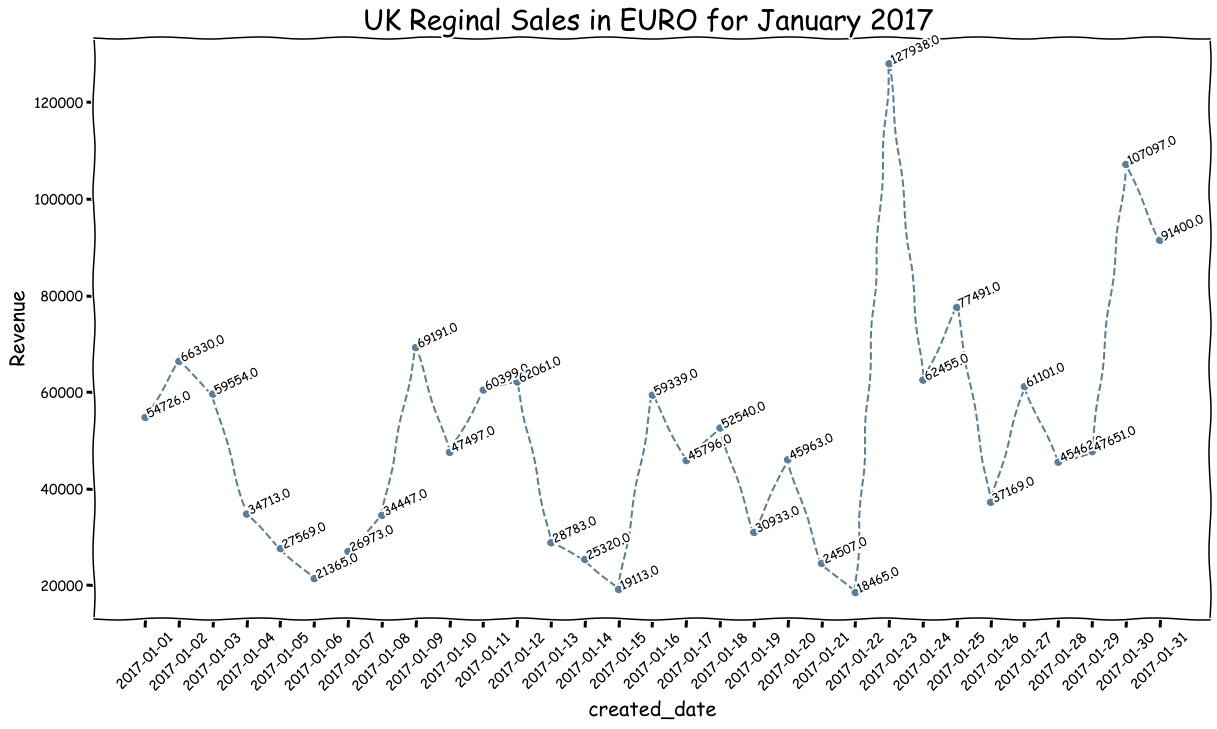

In [22]:
x=plottable['created_date']
y=plottable['total_paid_EUR']

plt.xkcd()
fig, ax = plt.subplots(figsize=(20, 10.7))
plt.plot(x, y,color = '#5a7d9a',linestyle='--',marker='o',linewidth=2,label = 'classfication',)
plt.xlabel("created_date", size=20)
plt.ylabel("Revenue", size=20)
plt.title('UK Reginal Sales in EURO for January 2017 ',size=28)
for index in range(len(x)):
    ax.text(x[index], y[index], y[index], size=12,rotation = 25)
plt.xticks(rotation = 45)
plt.show()
fig.savefig('UK_Reginal_Sales_in_EURO_for_January_2017.png', dpi=fig.dpi)

In [23]:
import seaborn as sns

/Users/weiling.p/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


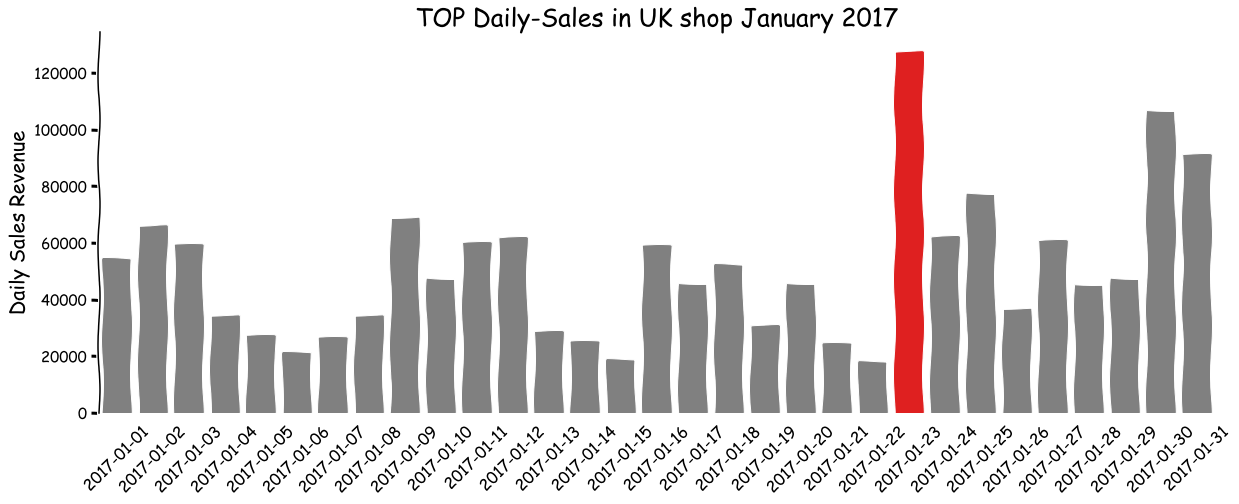

In [24]:
x=plottable['created_date']
y=plottable['total_paid_EUR'].astype(int)

spirit_top = plottable['total_paid_EUR']
colors = ['grey' if (s < max(spirit_top)) else 'red' for s in spirit_top]

fig, ax = plt.subplots(figsize=(20,7))
sns.set_style('white')
ax=sns.barplot(x, y,data=plottable, palette=colors)
plt.title('TOP Daily-Sales in UK shop January 2017', fontsize=25)
plt.xlabel(None)
plt.xticks(fontsize=16)
plt.ylabel('Daily Sales Revenue', fontsize=20)
plt.yticks(fontsize=15)
sns.despine(bottom=True)
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.xticks(rotation = 45)
plt.show()
fig.savefig('TOP_Daily-Sales_in_UK_shop_January_2017.png', dpi=fig.dpi)